In [ ]:
!pip install numpy
!pip install opencv-python
!pip install torch
!pip install torchvision
!pip install -U scikit-learn
!pip install timm

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from torchvision.utils import draw_segmentation_masks, save_image
import sklearn

from google.colab import drive
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.io import read_image, ImageReadMode
from pathlib import Path
import skimage
import cv2

import json
import os
import pickle


##**Load Dataset**

Assumes directory:

```
colab
| ocean_data
|  | train
|  |  | images
|  |  | annotations
|  | test
|  |  | images
|  |  |annotations
```



In [ ]:
drive.mount('/content/gdrive', force_remount=True)

# replace with current dataset location
root_file = '/content/gdrive/My Drive/colab/ocean_data'

Mounted at /content/gdrive


In [ ]:
train_imgs = []
train_annotations = []

train_dir = root_file + "/train"

for pth in os.listdir(train_dir + "/images"):
  train_imgs.append(train_dir + "/images" +"/"+pth)

for pth in os.listdir(train_dir + "/annotations"):
  train_annotations.append(train_dir + "/annotations" +"/"+pth)

# train_imgs.sort()
# train_annotations.sort()

print(len(train_imgs))
print(len(train_annotations))

65
65


In [ ]:
# separate by video
train_imgs_sep = []
train_annotations_sep = []
train_dir = root_file + "/train"

seps = [20, 38, 43]
curr = []
curr_an = []
for i in range(65):
  suff = ".jpg"
  if i >= 39:
    suff = ".png"
  img_pth = f"{train_dir}/images/{str(i) + suff}"
  ann_pth = f"{train_dir}/annotations/{str(i)}.json"
  curr.append(img_pth)
  curr_an.append(ann_pth)

  if i in seps:
    train_imgs_sep.append(curr)
    train_annotations_sep.append(curr_an)
    curr = []
    curr_an = []

train_imgs_sep.append(curr)
train_annotations_sep.append(curr_an)
print(train_imgs_sep)
print(train_annotations_sep)

[['/content/gdrive/My Drive/colab/ocean_data/train/images/0.jpg', '/content/gdrive/My Drive/colab/ocean_data/train/images/1.jpg', '/content/gdrive/My Drive/colab/ocean_data/train/images/2.jpg', '/content/gdrive/My Drive/colab/ocean_data/train/images/3.jpg', '/content/gdrive/My Drive/colab/ocean_data/train/images/4.jpg', '/content/gdrive/My Drive/colab/ocean_data/train/images/5.jpg', '/content/gdrive/My Drive/colab/ocean_data/train/images/6.jpg', '/content/gdrive/My Drive/colab/ocean_data/train/images/7.jpg', '/content/gdrive/My Drive/colab/ocean_data/train/images/8.jpg', '/content/gdrive/My Drive/colab/ocean_data/train/images/9.jpg', '/content/gdrive/My Drive/colab/ocean_data/train/images/10.jpg', '/content/gdrive/My Drive/colab/ocean_data/train/images/11.jpg', '/content/gdrive/My Drive/colab/ocean_data/train/images/12.jpg', '/content/gdrive/My Drive/colab/ocean_data/train/images/13.jpg', '/content/gdrive/My Drive/colab/ocean_data/train/images/14.jpg', '/content/gdrive/My Drive/colab/o

Assuming annotations by using: https://www.robots.ox.ac.uk/~vgg/software/via/

In [ ]:
def getMask(img, annotation):
  """
  Given an img and annotation (json) output from VGG Image annotator,
  output a list of masks (tensors where element is 1 if object, 0 otherwise)
  and the number of objects
  """
  polygons = [r['shape_attributes'] for r in annotation['regions']]
  num_obj = len(polygons)
  height, width = img.shape[1], img.shape[2]

  masks = []
  mask = np.zeros([height, width],
                        dtype=np.uint8)

  for i, p in enumerate(polygons):
            # Get indexes of pixels inside the polygon and set them to 1
            if 'all_points_y' in p:
              rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            else:
              rr, cc = skimage.draw.polygon(p['cy'], p['cx'])
            mask[rr, cc] = 1
            masks.append(mask)
            mask = np.zeros([height, width],
                        dtype=np.uint8)

  return masks, num_obj

In [ ]:
def getBoundingBoxes(mask):
  """
  Given a mask: tensor where 1 if object, 0 otherwise
  output bounding boxes (tensor with points that are the corner of the boxes)
  """
  x,y,w,h = cv2.boundingRect(mask)
  return torch.tensor([x, y, x+w, y+h])

In [ ]:
def LoadData(imgs, annotations, batch_size):
  batchImgs = []
  batchData = []

  choose = np.random.randint(0,len(imgs)-1)
  imgs = imgs[choose]
  annotations = annotations[choose]
  ref = read_image(imgs[0], ImageReadMode.RGB)


  start = 0
  if len(imgs) > batch_size:
    start = np.random.randint(0, len(imgs)-batch_size)

  for i in range(batch_size):
    idx = start + i

    img = read_image(imgs[idx], ImageReadMode.RGB)
    img = img - ref
    f = open(annotations[idx])
    annotation = json.load(f)

    masks, num_obj = getMask(img, annotation)
    # if num_obj == 0:
    #   return LoadData(batch_size)

    height, width = img.shape[1], img.shape[2]

    boxes = torch.zeros([num_obj,4], dtype=torch.float32)

    for i in range(num_obj):
      boxes[i] = getBoundingBoxes(masks[i])

    masks = torch.as_tensor(masks, dtype=torch.uint8)
    img = torch.as_tensor(img, dtype=torch.float32)
    data = {}
    data["boxes"] =  boxes
    data["labels"] =  torch.ones((num_obj,), dtype=torch.int64)
    data["masks"] = masks
    batchImgs.append(img)
    batchData.append(data)

  batchImgs = torch.stack([torch.as_tensor(d) for d in batchImgs],0)
  return batchImgs, batchData


In [ ]:
# example of using LoadData
batchSize = 1
batchImgs, batchData = LoadData(train_imgs_sep, train_annotations_sep, batchSize)
print(batchImgs)
print(batchData)

## **MaskRCNN Model**
Define model:

[Model docs](https://pytorch.org/vision/main/models/generated/torchvision.models.detection.maskrcnn_resnet50_fpn.html#torchvision.models.detection.maskrcnn_resnet50_fpn)

New model from standard weights:

In [ ]:
weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()
model = maskrcnn_resnet50_fpn(weights=weights, progress=False)

Load pretrained (from our data) model:

In [ ]:
model.load_state_dict(torch.load(root_file + "/model_90_epoch.json"))

<All keys matched successfully>

## **Training loop**

In [ ]:
def train(model, optimizer, epochs):

  for epoch in range(epochs):
    print("epoch: " + str(epoch))
    batch_size = 5
    images, targets = LoadData(train_imgs_sep, train_annotations_sep, batch_size)

    optimizer.zero_grad()
    loss_dict = model(images, targets)
    loss = sum(loss for loss in loss_dict.values())
    loss.backward()
    optimizer.step()


In [ ]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-5)
epochs = 10
model.train()
train(model, optimizer, epochs)

epoch: 0


<ipython-input-8-3d32be890c4f>:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  masks = torch.as_tensor(masks, dtype=torch.uint8)


epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9


In [ ]:
torch.save(model.state_dict(), root_file + "/model_100_epoch.json")

## **Running the Model**
Run model on data, outputs List[Dict[Tensor]], one for each input image with fields:
    
* boxes (FloatTensor[N, 4]): the predicted boxes in [x1, y1, x2, y2]
format, with 0 <= x1 < x2 <= W and 0 <= y1 < y2 <= H.
* labels (Int64Tensor[N]): the predicted labels for each instance
* scores (Tensor[N]): the scores or each instance
* masks (UInt8Tensor[N, 1, H, W]): the predicted masks for each instance, in 0-1 range. In order to obtain the final segmentation masks, the soft masks can be thresholded, generally with a value of 0.5 (mask >= 0.5)





In [ ]:
## look at 1 image
train_root = root_file + "/train"
img = read_image(train_root + "/images/2.jpg", ImageReadMode.RGB)
f = open(train_root + "/annotations/2.json")
annotation = json.load(f)
print(img.shape)
images = [transforms(img)]

torch.Size([3, 5460, 8192])


In [ ]:
## look at multiple images
images = []
images_raw = []
annotations = []
train_root = root_file + "/train"
val_root = root_file + "/val"
for i in range(9,14):
  img = read_image(val_root + f"/images/{str(i)}.jpg", ImageReadMode.RGB)
  f = open(val_root + f"/annotations/{str(i)}.json")
  annotation = json.load(f)
  images_raw.append(img)
  images.append(transforms(img))
  annotations.append(annotation)

In [ ]:
loaded_model = maskrcnn_resnet50_fpn(weights=weights, progress=False)
loaded_model.load_state_dict(torch.load(root_file + "/model_100_epoch.json"))
loaded_model.eval()

with torch.no_grad():
  output = loaded_model(images)

In [ ]:
pickle.dump(output, open(f"{val_root}/1.pckl", "wb"))

KeyboardInterrupt: ignored

In [ ]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.savefig(root_file + "/fluid_lens_test.png")

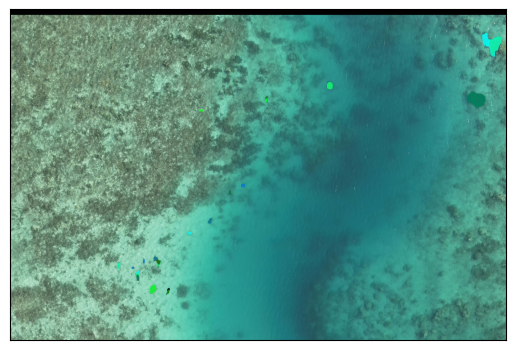

In [ ]:
thresh = 0.5
bool_mask = output[0]['masks'] > thresh

bool_mask = bool_mask.squeeze(1)

seg_img = draw_segmentation_masks(img, bool_mask, alpha=0.9)
show(seg_img)

## **Accuracy**


In [ ]:
def get_iou_score(img, label_mask, model_prediction_mask):
  """
  Inputs:
  img = tensor of the image
  label_mask = tensor/bitmask of true masks, with shape [number of objects, image height, image width]
  model_prediction_mask = tensor/bitmask outputted by model, with shape [number of objects, image height, image width]

  Outputs: float of iou score
  """
  pred_mask = model_prediction_mask > 0.5
  pred_mask = pred_mask.squeeze(1)

  label_mask_flat = np.zeros((label_mask.shape[1], label_mask.shape[2]))
  pred_mask_flat = np.zeros((pred_mask.shape[1], pred_mask.shape[2]))

  for i in range(label_mask.shape[0]):
    label_mask_flat = np.logical_or(label_mask_flat, label_mask[i, :, :])

  for i in range(pred_mask.shape[0]):
    pred_mask_flat = np.logical_or(pred_mask_flat, pred_mask[i, :, :])

  intersection = label_mask_flat * pred_mask_flat
  union = np.logical_or(label_mask_flat, pred_mask_flat).long()

  score = intersection.sum() / float(union.sum())
  return score.item()

In [ ]:
scores = []
for i in range(len(images_raw)):
  label_mask, num_obj = getMask(images_raw[i], annotations[i])
  label_mask = torch.as_tensor(label_mask)
  score = get_iou_score(label_mask, output[i]['masks'])
  print(score)
  scores.append(score)

In [ ]:
pickle.dump(scores, open(f"{val_root}/0.pckl", "wb"))

In [ ]:
score = get_iou_score(img, annotation, output[0]['masks'])
print(score)

<ipython-input-13-de7d67a7eaad>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  label_mask = torch.as_tensor(label_mask)


0.0


In [ ]:
val_root = root_file + "/val"
first = pickle.load(open(f"{val_root}/1.pckl", "rb"))
second = pickle.load(open(f"{val_root}/2.pckl", "rb"))

sum = np.sum(first + second)

In [ ]:
print(sum/15)

0.04101847844819228


## **Other models**

In [ ]:
from transformers import DetrForObjectDetection

In [ ]:
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
print(images[0])

tensor([[[0.0000, 0.0941, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0980, 0.5373, 0.5882,  ..., 0.3882, 0.3961, 0.3961],
         [0.0000, 0.4824, 0.5882,  ..., 0.3804, 0.3843, 0.3882],
         ...,
         [0.0000, 0.6471, 0.6588,  ..., 0.2745, 0.2667, 0.2588],
         [0.0000, 0.6627, 0.6706,  ..., 0.2706, 0.2549, 0.2392],
         [0.0000, 0.6471, 0.6549,  ..., 0.2706, 0.2471, 0.2275]],

        [[0.0196, 0.1490, 0.0235,  ..., 0.0549, 0.0510, 0.0471],
         [0.1451, 0.5922, 0.6549,  ..., 0.5569, 0.5569, 0.5569],
         [0.0235, 0.5490, 0.6588,  ..., 0.5765, 0.5804, 0.5843],
         ...,
         [0.0549, 0.7725, 0.7843,  ..., 0.4902, 0.4745, 0.4667],
         [0.0706, 0.7882, 0.7961,  ..., 0.4863, 0.4627, 0.4471],
         [0.0588, 0.7725, 0.7804,  ..., 0.4863, 0.4549, 0.4353]],

        [[0.0000, 0.0902, 0.0000,  ..., 0.0235, 0.0235, 0.0196],
         [0.0902, 0.5333, 0.5922,  ..., 0.5216, 0.5255, 0.5255],
         [0.0000, 0.4863, 0.5961,  ..., 0.5333, 0.5373, 0.

In [ ]:
with torch.no_grad():
  images = torch.stack([img for img in images])
  output = model(images)